In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoFeatureExtractor, AutoTokenizer, ClapModel
import torchaudio

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# Initialize model
model = ClapModel.from_pretrained("laion/clap-htsat-unfused")
tokenizer = AutoTokenizer.from_pretrained("laion/clap-htsat-unfused")
feature_extractor = AutoFeatureExtractor.from_pretrained("laion/clap-htsat-unfused")            

model.to(device)

def get_clap_emb(input_type, file_path):

    if input_type == 1:
        
        audio_sample, sr = torchaudio.load(file_path)
        audio_sample = torchaudio.functional.resample(audio_sample, orig_freq=sr, new_freq=48000)[0]
        inputs = feature_extractor(audio_sample, sampling_rate=48000, return_tensors="pt").to(device)
        audio_features = model.get_audio_features(**inputs)
        return audio_features
    
    elif input_type == 3:
        inputs = tokenizer([file_path], padding=True, return_tensors="pt").to(device)
        text_features = model.get_text_features(**inputs)
    
        return text_features

In [ ]:
# input_type = int(input('1 - audio\n2 - image\n3 - text'))
# file_path = input('File path/text prompt: ')
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

data_path = 'exploration'
# data_path = '5_speakers'

files = []
points = []
colors = []

for file_path in [os.path.join(data_path, f) for f in os.listdir(data_path)]:

    if file_path.endswith('.wav'):
        input_type = 1
        # continue

    elif file_path.endswith('.png') or file_path.endswith('.jpg') or file_path.endswith('.jpeg'):
        input_type = 2
        continue

    elif file_path.endswith('.txt'):
        input_type = 3
        with open(file_path, 'r') as file:
            file_path = file.read().replace('\n', '')

    else:
        raise Exception(f'File type {file_path.split(".")[-1]} not accepted.')

    emb = get_clap_emb(input_type, file_path)

    points.append(emb.cpu().detach().numpy()[0])
    colors.append(input_type)
    files.append(file_path.split('/')[-1])

points = np.array(points)
colors = np.array(colors)

print(points.shape, colors.shape)

In [37]:
pca = TSNE(n_components=2, perplexity=5, init='pca', random_state=0)
# pca = PCA(n_components=2)
X = pca.fit_transform(points)
print(X.shape)

(11, 2)


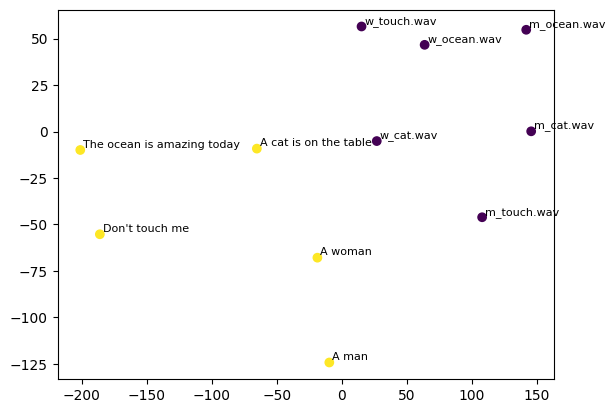

In [38]:

def plot_emb(X, colors, names):
    # plot data
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    for i, txt in enumerate(names):
        plt.annotate(txt, (X[i, 0], X[i, 1]), fontsize=8, xytext=(2, 2), textcoords='offset points')
        
    plt.show()

plot_emb(X, colors, files)